In [1]:
import argparse
import time
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import itertools
import os
import re
import pandas as pd

In [2]:
def get_cm_metrics(confusion_matrix, labels, verbose=False):
    n = len(labels)

    supports = [0] * n
    vp = [0] * n
    fp = [0] * n
    fn = [0] * n
    precisions = [0] * n
    recalls = [0] * n
    fscores = [0] * n

    for x in range(n):
        for y in range(n):
            value = confusion_matrix[x][y]
            supports[x] += value
            if x == y:
                vp[x] += value
            else:
                fp[y] += value
                fn[x] += value

    for x in range(n):
        recalls[x] = vp[x] / (vp[x] + fn[x])
        precisions[x] = vp[x] / (vp[x] + fp[x])

        if precisions[x] == 0 or recalls[x] == 0:
            fscores[x] = 0
        else:
            fscores[x] = 2 * (precisions[x] * recalls[x]) / \
                (precisions[x] + recalls[x])

    if verbose:
        print()
        print(''.rjust(30), 'precision'.rjust(10), 'recall'.rjust(
            10), 'f1-score'.rjust(10), 'support'.rjust(10))
        print()
        for x in range(n):
            print(labels[x].ljust(30),
                  '{:.2f}'.format(precisions[x]).rjust(10),
                  '{:.2f}'.format(recalls[x]).rjust(10),
                  '{:.2f}'.format(fscores[x]).rjust(10),
                  '{}'.format(supports[x]).rjust(10))
        print()
    accuracy = sum(vp) / sum(supports)
    avg_fscore = sum(fscores) / n

    return {
        'F1_scores': fscores,
        'accuracy': accuracy,
        'macro_F1': avg_fscore,
        'supports': supports,
        'precisions': precisions,
        'recalls': recalls,
    }


def plot_confusion_matrix(cm,
                          labels,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False,
                          normalize_color=True,
                          show_zero=True,
                          clear_diagonal=False,
                          output_file=None,
                          simple=False,
                          figsize=(16, 12),
                          verbose=False):

    metrics = get_cm_metrics(cm, labels, verbose)
    supports = metrics['supports']
    labels = [f"{labels[i]} ({supports[i]})" for i in range(len(labels))]

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    macro_f1 = metrics['macro_F1']

    if clear_diagonal:
        for i in range(cm.shape[0]):
            cm[i, i] = 0

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    fig_x = max(len(labels) // 10, 1)
    figsize = (figsize[0] * fig_x, figsize[1] * fig_x)

    plt.figure(figsize=figsize)

    matrix = cm
    if normalize_color:
        matrix = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(matrix, interpolation="nearest", cmap=cmap)
    plt.title(title)

    if labels is not None:
        tick_marks = np.arange(len(labels))
        plt.xticks(tick_marks, labels, rotation=45, ha='right')
        plt.yticks(tick_marks, labels)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = matrix.max() / 2

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if show_zero or cm[i, j] > 0:
            if normalize:
                plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if matrix[i, j] > thresh else "black")
            else:
                plt.text(j, i, "{:,}\n{:0.1f}%".format(cm[i, j], cm_normalized[i, j] * 100),
                         horizontalalignment="center",
                         verticalalignment="center",
                         color="white" if matrix[i, j] > thresh else "black")

    if not simple:
        ax = plt.gca()
        plt.tick_params(axis='x', labelbottom=True,
                        labeltop=True, bottom=True, top=True)
        plt.tick_params(axis='y', labelright=True)

        # Rotate and align top ticklabels
        plt.setp([tick.label2 for tick in ax.xaxis.get_major_ticks()], rotation=45,
                 ha="left", va="center", rotation_mode="anchor")

    plt.margins(1)
    plt.ylabel('True label')
    plt.xlabel('Predicted label\n' +
               'accuracy={:0.4f}\n'.format(accuracy) +
               'macro-f1={:0.4f}\n'.format(macro_f1))
    plt.rcParams['figure.facecolor'] = 'white'

    plt.tight_layout()

    if output_file:
        plt.savefig(output_file)
        print(f'Saved plot result to {output_file}')
    else:
        plt.show()


def get_confusion_matrix(log_file):
    info = {
        'name': log_file.replace('/', '-'),
        'metrics': []
    }
    result_matrix = None
    labels = []

    log_date = list(re.finditer("\d\d\d\d-\d\d-\d\d_\d\dh\d\d", log_file))

    if len(log_date) > 0:
        info['date'] = log_date[0].group()[:10]

    matrix_expressions = "Confusion Matrix(.|\n)*?\n\n\n"
    trainining_name_exp = "data:(.*)"
    trainining_date_exp = "Result folder:(.*)"

    with open(log_file) as file:
        txt = file.read()

        names = list(re.finditer(trainining_name_exp, txt))
        dates = list(re.finditer(trainining_date_exp, txt))

        if len(names) > 0:
            info['name'] = names[0].group().split(':')[-1].strip()
        if len(dates) > 0:
            date_line = dates[0].group().split(':')[-1].strip()

            training_date = date_line.split('/')[-1][:10]
            info['date'] = training_date

        res = re.finditer(matrix_expressions, txt)

        for r in res:
            matrix_log = r.group()

            labels = []
            labels_str = re.search(
                'Classification Report(.|\n)*?\d\n\n', matrix_log).group()

            for class_line in labels_str.split('\n'):

                text_line = re.search(
                    '(.*?)([0-9].[0-9][0-9])', class_line)

                if text_line is None:
                    continue

                line_values = text_line.group().split()
                class_name = ' '.join(line_values[:-1])
                if class_name:
                    labels.append(class_name)

            matrix_str = re.search('\[\[(.|\n)*?\]\]', matrix_log).group()

            numbers = []

            line_end = False

            for matrix_line in matrix_str.split(']'):
                numbers_str = re.findall('\d+', matrix_line)

                values = [int(x) for x in numbers_str]

                if len(values) > 0:
                    numbers.append(values)

            fold_matrix = np.array(numbers)

            info['metrics'].append(get_cm_metrics(fold_matrix, labels))

            if type(result_matrix) is np.ndarray:
                result_matrix = np.add(result_matrix, fold_matrix)
            else:
                result_matrix = np.array(numbers)
    return result_matrix, labels, info


def plot_line_chart(y, x, smooth_sigma=0.0, output_file="", title=""):

    fig1 = plt.figure(figsize=(15, 5))
    plt1 = fig1.add_subplot(111)
    plt1.set_title(title)
    plt1.set_ylabel("Accuracy", fontsize="large")
    plt1.set_xlabel("Epochs", fontsize="large")

    acc_val_text = (
        "Validation\n"
        + "Mean: {:.2f}\n"
        + "Max: {:.2f}\n"
        + "Min: {:.2f}\n"
        + "Std: {:.2f}\n"
        + "Final: {:.2f}"
    ).format(
        y.mean(), y.max(), y.min(
        ), y.std(), y[-1]
    )

    if smooth_sigma > 0:
        y = gaussian_filter1d(val_acc, sigma=smooth_sigma)

    plt1.plot(x, y, "b")

    plt1.text(
        0.88,
        0.4,
        acc_val_text,
        transform=plt1.transAxes,
        fontsize=12,
        verticalalignment="top",
        bbox=dict(boxstyle="round", facecolor="blue", alpha=0.15),
    )
    if output_file:
        plt.savefig(output_file)


def process_pred_file(pred_file):
    df = pd.read_csv(pred_file, index_col=0)

    max_epoch = df['epoch'].max()

    labels = df['label'].unique().tolist()

    # print('labels', labels)

    accuracy = []
    epochs = []

    total_metrics = {
        # 'epochs': []
    }

    for epoch in range(1, max_epoch + 1):
        # print(f'Processing epoch {epoch}')

        df_epoch = df[df['epoch'] == epoch]

        cm = np.zeros([len(labels)] * 2)

        for row in df_epoch.values:
            true_label = row[2]
            true_label_index = labels.index(true_label)

            pred_label = np.argmax(row[3:])

            cm[true_label_index][pred_label] += 1

        metrics = get_cm_metrics(cm, labels, verbose=False)

        # print(' ----> accuracy',
        #       metrics['accuracy'], '----> f1', metrics['macro_f1'])

        # total_metrics['epochs'].append(epoch)

        for metric in metrics.keys():

            if type(metrics[metric]) is list:
                continue

            if metric not in total_metrics:
                total_metrics[metric] = []
            # print('appending', metric, metrics[metric])
            total_metrics[metric].append(metrics[metric])

        # accuracy.append(metrics['accuracy'])
        # epochs.append(epoch)

    # print('accuracy', accuracy)
    # print('epochs', epochs)
    return total_metrics


def plot_labels_metrics(cm, labels,
                        title='Confusion matrix',
                        cmap=None,
                        normalize=False,
                        normalize_color=True,
                        show_zero=True,
                        clear_diagonal=False,
                        output_file=None,
                        simple=False,
                        figsize=(10, 10),
                        verbose=False,
                        sort_metric=None,
                        log_info=None):
    metrics = get_cm_metrics(cm, labels, verbose)

    n_labels = len(labels)

    label_idx = list(range(n_labels))

    if sort_metric:
        sval_idx = sorted(
            zip(metrics[sort_metric], range(n_labels)), reverse=True)
        label_idx = [v[1] for v in sval_idx]

    precisions = [metrics['precisions'][i] for i in label_idx]
    recalls = [metrics['recalls'][i] for i in label_idx]
    fscores = [metrics['F1_scores'][i] for i in label_idx]
    supports = [metrics['supports'][i] for i in label_idx]
    f1_macro = metrics['macro_F1']
    accuracy = metrics['accuracy']
    labels = [f'{labels[i]} ({metrics["supports"][i]})' for i in label_idx]

    labels_std = []

#     for m in ['F1_scores', 'precisions', 'recalls']:
#         m_std = []
#         for i in label_idx:
#             lbl_m = [x[m][i] for x in log_info['metrics']]
#             lbl_std = np.std(lbl_m)
#             m_std.append(lbl_std)
#         labels_std.append(m_std)

    fig_x = max(len(labels) // 10, 1)
    figsize = (10, n_labels * 1.5)

    plt.figure(figsize=figsize)

    fig, ax = plt.subplots(figsize=figsize)
    index = np.arange(n_labels)
    bar_height = 0.2
    opacity = 0.8

    rects3 = plt.barh(index - bar_height, fscores, bar_height,
                      alpha=opacity,
#                       xerr=labels_std[0],
                      color='r',
                      label='F1-score')

    rects1 = plt.barh(index, precisions, bar_height,
                      alpha=opacity,
#                       xerr=labels_std[1],
                      color='b',
                      label='Precision')

    rects2 = plt.barh(index + bar_height, recalls, bar_height,
                      alpha=opacity,
#                       xerr=labels_std[2],
                      color='g',
                      label='Recall')

    ax.invert_yaxis()
    ax.set_yticks(index)
    ax.set_yticklabels(labels)

    plt.xlabel('Performace\n' +
               'Accuracy = {:.2f}\n'.format(accuracy) +
               'F1-Macro = {:.2f}'.format(f1_macro))
    plt.ylabel('Labels')
    plt.title(title)
    # plt.xticks(index + bar_width, labels)
    plt.legend()

    for i in range(n_labels):
        plt.text(x=0.01, y=i+0.1, bbox=dict(facecolor='white', alpha=0.9),
                 s='f1 = {:.2f}'.format(fscores[i]) +
                 '\np = {:.2f}'.format(precisions[i]) +
                 '\nr = {:.2f}'.format(recalls[i])
                 )

    plt.tight_layout()

    if output_file:
        print(f'Saving metric in {output_file}')
        plt.savefig(output_file)

In [3]:
def main(args):
    input_files = args.input_files
    output_folder = args.output_folder

    os.makedirs(output_folder, exist_ok=True)

    for i, log_file in enumerate(input_files):
        print(f'Processing {i+1}/{len(input_files)} {log_file} ...')

        if args.plot == 'preds':
            metrics = process_pred_file(log_file)

            for k, v in metrics.items():
                epochs = np.arange(1, len(v) + 1)
                metric_list = np.array(v)

                file_title = log_file.replace('/', '_').replace('.csv', '')

                title = f"{file_title}: {k.capitalize()} per Epoch"
                output_file = f"{output_folder}/{file_title}-{k}.png"

                plot_line_chart(metric_list, epochs, title=title,
                                output_file=output_file)
        elif args.plot == 'label-metrics':
            confusion_matrix, labels, log_info = get_confusion_matrix(log_file)

            log_date = log_info["date"] if "date" in log_info else 'no-date'

            metrics_file = f'{output_folder}/{log_info["name"]}-label-metrics-{log_date}.png'

            title = f'Label metrics: {log_info["name"]}\n' + \
                    f'Bars represent the average metric values over {len(log_info["metrics"])} folds.\n' + \
                'Error bars represent 1 standard deviation.'

            plot_labels_metrics(
                cm=confusion_matrix,
                log_info=log_info,
                normalize=False,
                labels=labels,
                show_zero=False,
                title=title,
                clear_diagonal=False,
                output_file=metrics_file,
                verbose=args.verbose,
                sort_metric=args.sort_metric
            )
        elif args.plot == 'confusion-matrix':
            confusion_matrix, labels, log_info = get_confusion_matrix(log_file)

            matrix_file = f'{output_folder}/{log_info["name"]}-confusion-matrix-{log_info["date"]}.png'

            plot_confusion_matrix(
                cm=confusion_matrix,
                normalize=False,
                labels=labels,
                show_zero=False,
                title="Confusion Matrix: {}".format(log_info['name']),
                clear_diagonal=False,
                output_file=matrix_file,
                verbose=args.verbose,
            )

            if args.with_raw:
                raw_file = f'{output_folder}/raw-matrix.txt'

                max_v_size = len(str(confusion_matrix.max()))

                with open(raw_file, 'a') as file:
                    file.writelines([
                        f'# {log_info["name"]}\n',
                        f'# label: {labels}\n',
                        '\n',
                        '['
                    ])

                    for i, line in enumerate(confusion_matrix):
                        if i > 0:
                            file.write(' ')
                        f_line = ' '.join(
                            [str(v).rjust(max_v_size) for v in line])
                        file.writelines(['[', f_line, ']'])

                        if i < len(confusion_matrix):
                            file.write('\n')
                        else:
                            file.write(']')

                    file.writelines(['\n', '\n'])
        print()

Saving metric in matrix.png
Saved plot result to matrix.png


<Figure size 720x216 with 0 Axes>

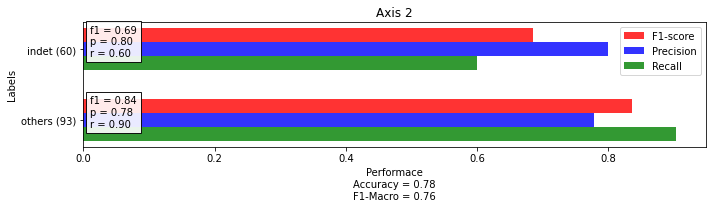

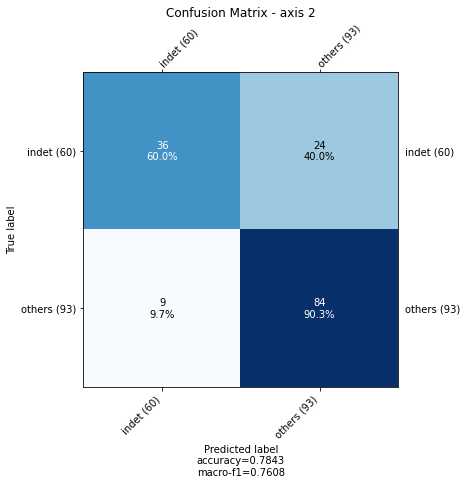

In [6]:
# confusion_matrix = np.array([[66,2,5], [1,26,2], [10,4,16]])
# confusion_matrix = np.array([[67, 2, 4], [0, 26, 3], [7, 7, 16]])
confusion_matrix = np.array([[36, 24],[9, 84]])
labels = ["indet", "others"]

plot_labels_metrics(
                cm=confusion_matrix,
                normalize=False,
                labels=labels,
                show_zero=False,
                title='Axis 2',
                clear_diagonal=False,
                figsize=(15, 105),
                output_file="matrix.png"
            )
plot_confusion_matrix(
                cm=confusion_matrix,
                normalize=False,
                labels=labels,
                show_zero=False,
                title="Confusion Matrix - axis 2",
                clear_diagonal=False,
                output_file="matrix.png",
                figsize=(10, 7)
#                 verbose=args.verbose,
            )

Saving metric in matrix.png
Saved plot result to matrix.png


<Figure size 720x216 with 0 Axes>

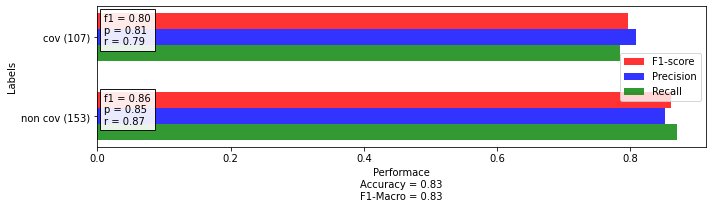

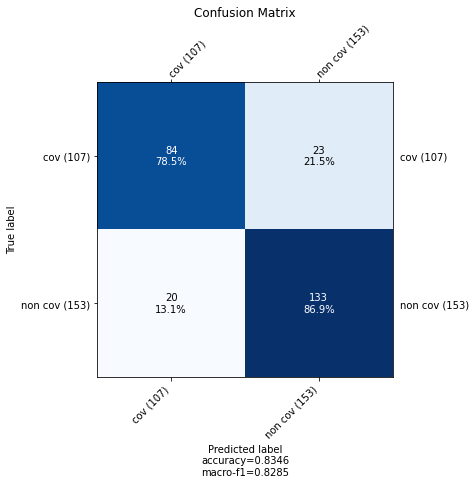

In [4]:
# 6 eixos
# 42 imagens 
# 256 × 256 
# concatenate
# tf 22
confusion_matrix = np.array([[84,23],[20,133]])

labels = ["cov", "non cov"]
plot_labels_metrics(
                cm=confusion_matrix,
                normalize=False,
                labels=labels,
                show_zero=False,
                title='',
                clear_diagonal=False,
                figsize=(15, 105),
                output_file="matrix.png"
            )
plot_confusion_matrix(
                cm=confusion_matrix,
                normalize=False,
                labels=labels,
                show_zero=False,
                title="Confusion Matrix",
                clear_diagonal=False,
                output_file="matrix.png",
                figsize=(10, 7)
#                 verbose=args.verbose,
            )

Saving metric in matrix.png
Saved plot result to matrix.png


<Figure size 720x216 with 0 Axes>

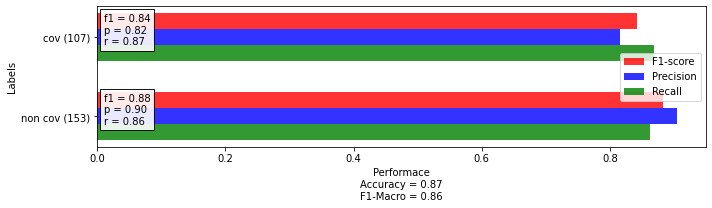

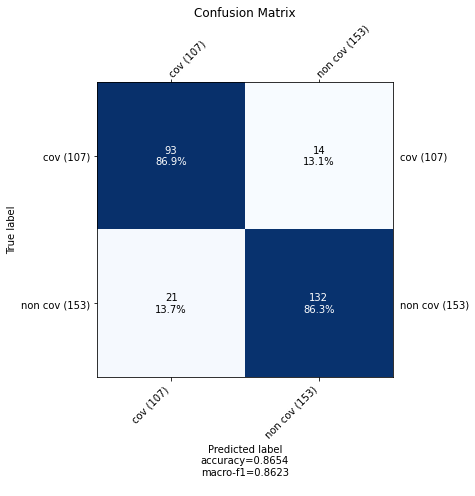

In [6]:
# 1,2 ,4 eixos
# 42 imagens 
# 256 × 256 
# concatenate
confusion_matrix = np.array([[93,14],[21,132]])

labels = ["cov", "non cov"]
plot_labels_metrics(
                cm=confusion_matrix,
                normalize=False,
                labels=labels,
                show_zero=False,
                title='',
                clear_diagonal=False,
                figsize=(15, 105),
                output_file="matrix.png"
            )
plot_confusion_matrix(
                cm=confusion_matrix,
                normalize=False,
                labels=labels,
                show_zero=False,
                title="Confusion Matrix",
                clear_diagonal=False,
                output_file="matrix.png",
                figsize=(10, 7)
#                 verbose=args.verbose,
            )

Saving metric in matrix.png
Saved plot result to matrix.png


<Figure size 720x216 with 0 Axes>

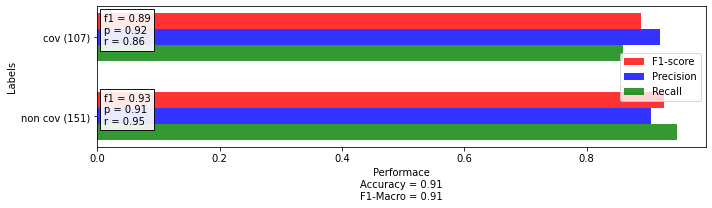

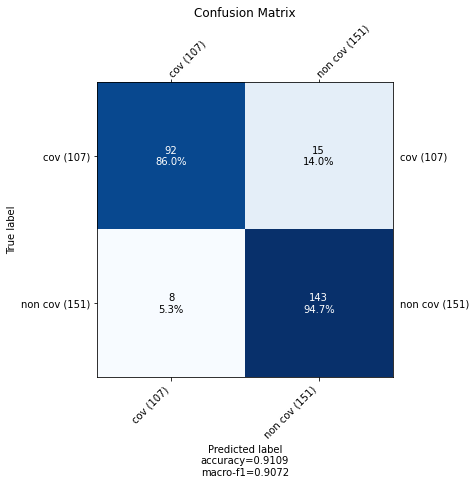

In [7]:
# 1,2 ,4 eixos
# 42 imagens 
# 256 × 256 
# concatenate
confusion_matrix = np.array([[92,15],[8,143]])

labels = ["cov", "non cov"]
plot_labels_metrics(
                cm=confusion_matrix,
                normalize=False,
                labels=labels,
                show_zero=False,
                title='',
                clear_diagonal=False,
                figsize=(15, 105),
                output_file="matrix.png"
            )
plot_confusion_matrix(
                cm=confusion_matrix,
                normalize=False,
                labels=labels,
                show_zero=False,
                title="Confusion Matrix",
                clear_diagonal=False,
                output_file="matrix.png",
                figsize=(10, 7)
#                 verbose=args.verbose,
            )

Saving metric in matrix.png
Saved plot result to matrix.png
Saving metric in matrix.png
Saved plot result to matrix.png


<Figure size 720x216 with 0 Axes>

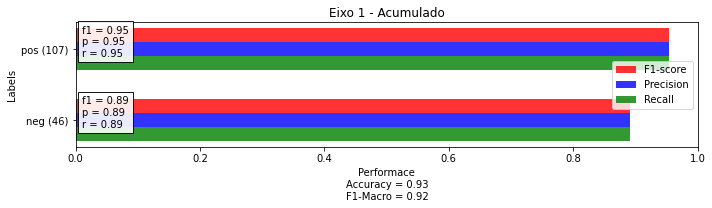

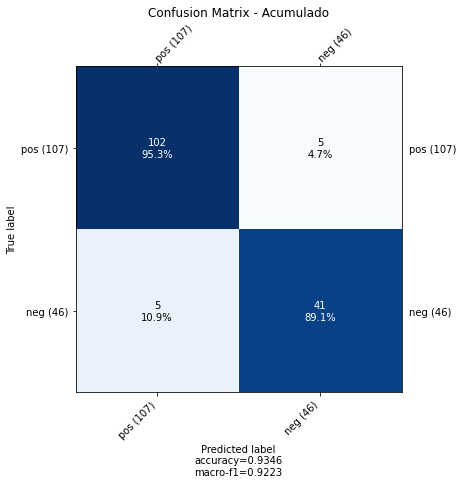

<Figure size 720x216 with 0 Axes>

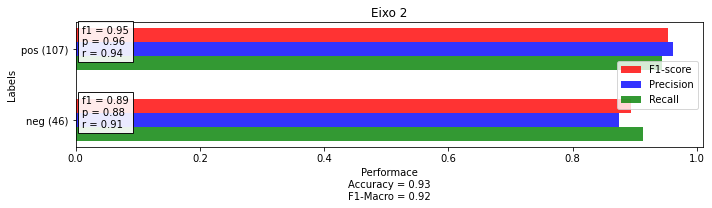

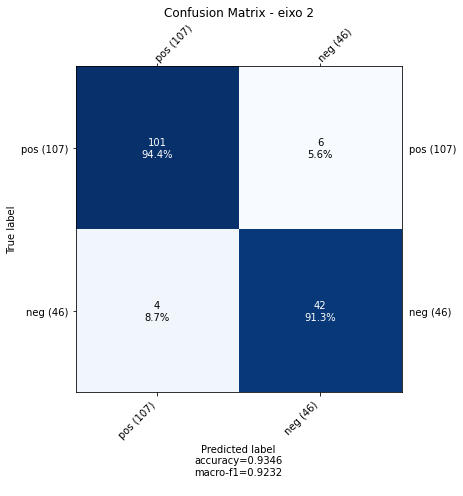

In [10]:
''' VGG16 '''
# confusion_matrix = np.array([[66,2,5], [1,26,2], [10,4,16]])
# confusion_matrix = np.array([[67, 2, 4], [0, 26, 3], [7, 7, 16]])
confusion_matrix = np.array([[102,5],[5,41]])

labels = ["pos", "neg"]
plot_labels_metrics(
                cm=confusion_matrix,
                normalize=False,
                labels=labels,
                show_zero=False,
                title='Eixo 1 - Acumulado',
                clear_diagonal=False,
                figsize=(15, 105),
                output_file="matrix.png"
            )
plot_confusion_matrix(
                cm=confusion_matrix,
                normalize=False,
                labels=labels,
                show_zero=False,
                title="Confusion Matrix - Acumulado",
                clear_diagonal=False,
                output_file="matrix.png",
                figsize=(10, 7)
#                 verbose=args.verbose,
            )


confusion_matrix = np.array([[101,6],[4,42]])

labels = ["pos", "neg"]
plot_labels_metrics(
                cm=confusion_matrix,
                normalize=False,
                labels=labels,
                show_zero=False,
                title='Eixo 2',
                clear_diagonal=False,
                figsize=(15, 105),
                output_file="matrix.png"
            )
plot_confusion_matrix(
                cm=confusion_matrix,
                normalize=False,
                labels=labels,
                show_zero=False,
                title="Confusion Matrix - eixo 2",
                clear_diagonal=False,
                output_file="matrix.png",
                figsize=(10, 7)
#                 verbose=args.verbose,
            )

Saving metric in matrix.png
Saved plot result to matrix.png
Saving metric in matrix.png
Saved plot result to matrix.png


<Figure size 720x216 with 0 Axes>

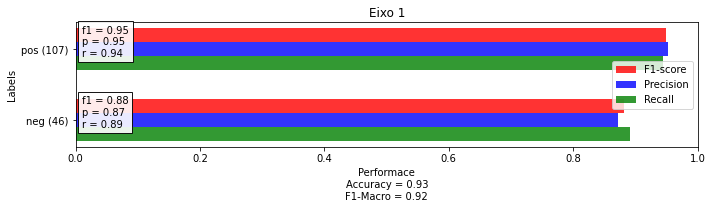

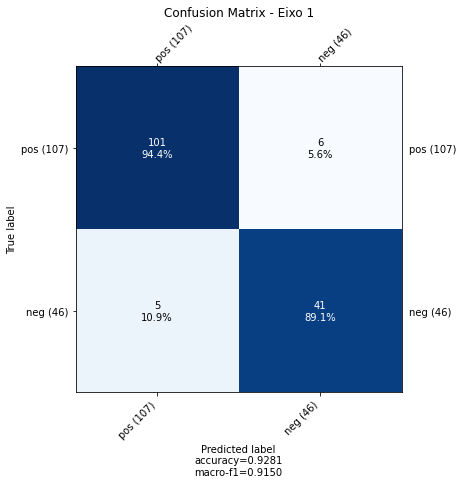

<Figure size 720x216 with 0 Axes>

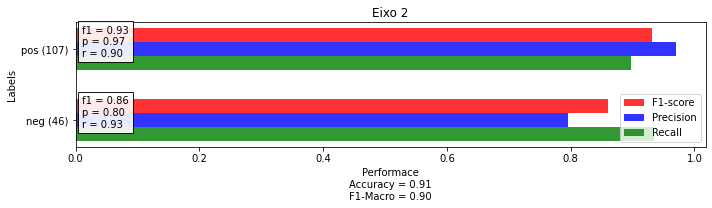

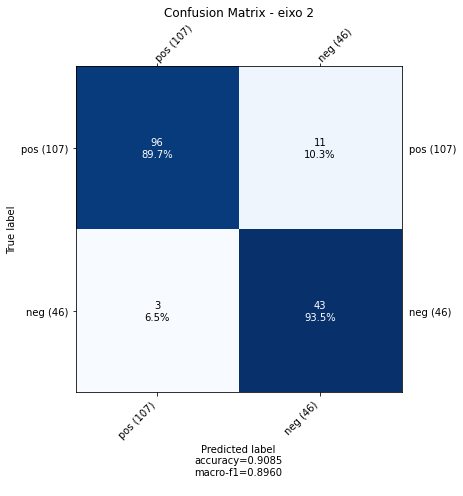

In [10]:
''' RESNET 50 '''

confusion_matrix = np.array([[101,6],[5,41]])

labels = ["pos", "neg"]
plot_labels_metrics(
                cm=confusion_matrix,
                normalize=False,
                labels=labels,
                show_zero=False,
                title='Eixo 1',
                clear_diagonal=False,
                figsize=(15, 105),
                output_file="matrix.png"
            )
plot_confusion_matrix(
                cm=confusion_matrix,
                normalize=False,
                labels=labels,
                show_zero=False,
                title="Confusion Matrix - Eixo 1",
                clear_diagonal=False,
                output_file="matrix.png",
                figsize=(10, 7)
#                 verbose=args.verbose,
            )


confusion_matrix = np.array([[96,11],[3,43]])

labels = ["pos", "neg"]
plot_labels_metrics(
                cm=confusion_matrix,
                normalize=False,
                labels=labels,
                show_zero=False,
                title='Eixo 2',
                clear_diagonal=False,
                figsize=(15, 105),
                output_file="matrix.png"
            )
plot_confusion_matrix(
                cm=confusion_matrix,
                normalize=False,
                labels=labels,
                show_zero=False,
                title="Confusion Matrix - eixo 2",
                clear_diagonal=False,
                output_file="matrix.png",
                figsize=(10, 7)
#                 verbose=args.verbose,
            )

In [ ]:
#     parser = argparse.ArgumentParser()

#     parser.add_argument('input_files', metavar='INPUT_FILES', nargs='+')
#     parser.add_argument('output_folder', metavar='OUTPUT_FOLDER')
#     parser.add_argument('--model', metavar='model')
#     parser.add_argument('--sort-metric', metavar='sort_metric')
#     parser.add_argument('--plot', metavar='plot')
#     parser.add_argument('--eps', metavar='eps', type=int)
#     parser.add_argument('--increment', dest='increment', type=float)
#     parser.add_argument('--debug', dest='debug', action='store_true')
#     parser.add_argument('--with-raw', dest='with_raw', action='store_true')
#     parser.add_argument('--preds', dest='preds', action='store_true')
#     parser.add_argument('--verbose', dest='verbose', action='store_true')

#     parser.set_defaults(debug=False, with_raw=False,
#                         plot='confusion-matrix', verbose=False)

#     args = parser.parse_args()

#     import json

#     print('Input')
#     print(json.dumps(args.__dict__, indent=2))
#     print()

#     start = time.ctime()
#     args = {}
#     args['input_file'] = 
#     args['output_folder'] =
#     args['plot'] = True
#     main(args)
#     print('Process started at ', start)
#     print('Process finished at ', time.ctime())